In [3]:
import pandas as pd

# Load the CSV file into a DataFrame
nba_data = pd.read_csv('nba_22features.csv')

# Display the first few rows of the DataFrame
nba_data.head()

,game_id,Game Date,Home Days Since Last Game,Home Games Last 7 Days,Home Is Back-to-Back,Away Days Since Last Game,Away Games Last 7 Days,Away Is Back-to-Back,Away Team Recent 10 Win Rate,Home Team Recent 10 Win Rate,...,home_ast_avg_last10,home_plus_minus_avg_last10,away_pts_avg_last10,away_reb_avg_last10,away_ast_avg_last10,away_plus_minus_avg_last10,target,home_injury_count,away_injury_count,is_playoffs
0,29900423,2000-01-02,5.0,1,False,3.0,1,False,0.4,0.7,...,24.7,-0.6,102.2,45.4,20.0,2.4,1.0,0,0,False
1,29900427,2000-01-03,5.0,2,False,5.0,1,False,0.6,0.4,...,19.1,-0.5,103.9,42.6,21.7,4.5,0.0,0,0,False
2,29900426,2000-01-03,4.0,1,False,8.0,0,False,0.8,0.4,...,21.8,-0.5,97.1,43.0,24.4,-3.3,1.0,0,0,False
3,29900429,2000-01-03,5.0,2,False,11.0,0,False,0.7,0.8,...,24.3,6.7,100.5,46.1,22.1,2.7,1.0,0,0,False
4,29900428,2000-01-03,5.0,2,False,13.0,0,False,0.3,0.2,...,19.5,-14.4,96.6,44.8,24.4,6.1,0.0,0,0,False


In [4]:
from sklearn.model_selection import train_test_split

X = nba_data.drop(columns=['game_id', 'Game Date', 'target'])
y = nba_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23072, 21), (5768, 21), (23072,), (5768,))

In [5]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.impute import SimpleImputer

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Convert regression output to binary classification
y_train_binary = np.where(y_train > 0.5, 1, 0)
y_test_binary = np.where(y_test > 0.5, 1, 0)

# Train a logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train_binary)

# Predict on the test set
y_pred = lr.predict(X_test)

print(classification_report(y_test_binary, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.41      0.48      2364
           1       0.66      0.81      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.63      0.61      0.61      5768
weighted avg       0.64      0.65      0.63      5768



C:\Users\fanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


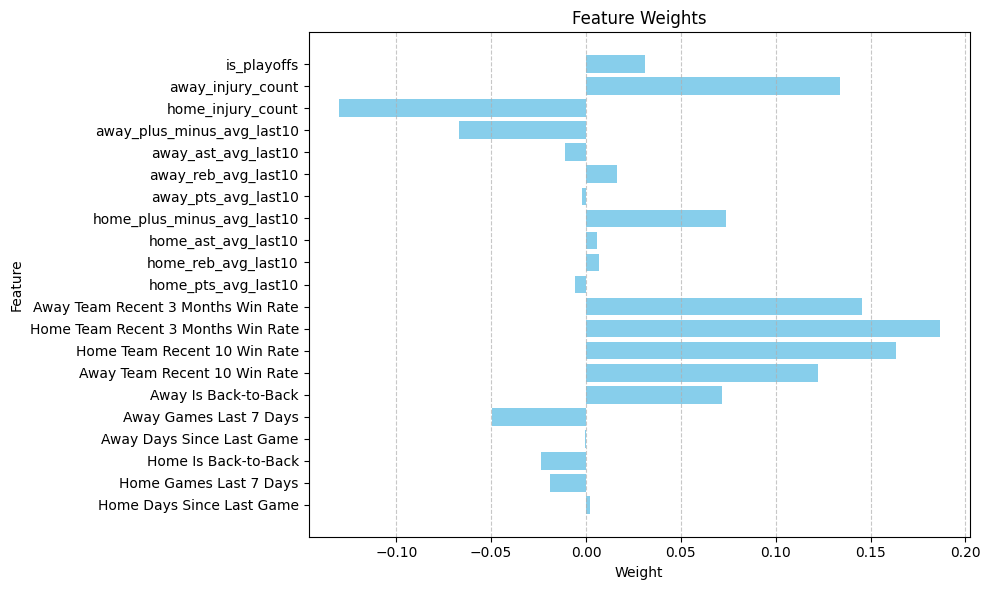

In [6]:
import matplotlib.pyplot as plt

# 获取特征名称和对应的权重
feature_names = X_train.columns
weights = lr.coef_.flatten()  # 将权重展平为1D数组

# 可视化权重
plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Weights')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 使用GridSearchCV寻找最佳alpha值
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# 使用最佳参数训练Lasso模型
best_alpha = grid_search.best_params_['alpha']
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_lasso = lasso.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred_lasso)

print(f"Best alpha: {best_alpha}")

y_pred_lasso_binary = np.where(y_pred_lasso > 0.5, 1, 0)
print(classification_report(y_test_binary, y_pred_lasso_binary))

Best alpha: 0.0001
              precision    recall  f1-score   support

           0       0.61      0.43      0.50      2364
           1       0.67      0.81      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.64      0.62      0.62      5768
weighted avg       0.65      0.65      0.64      5768



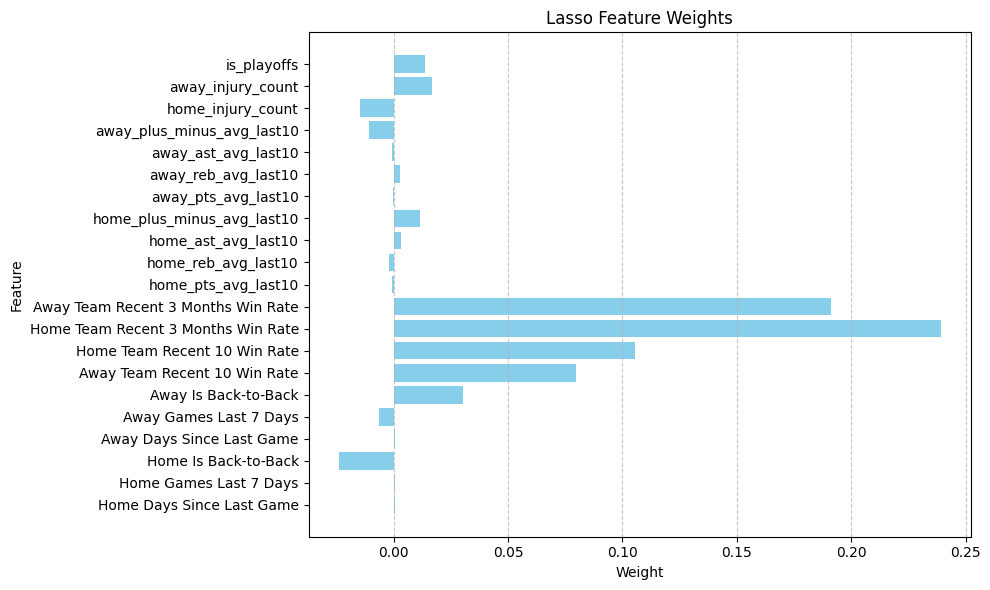

In [8]:
# 获取特征名称和对应的权重
feature_names = X_train.columns
weights = lasso.coef_  # 获取Lasso模型的权重

# 可视化权重
plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Lasso Feature Weights')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.linear_model import Ridge

# 使用GridSearchCV寻找最佳alpha值
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_ridge = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_ridge.fit(X_train, y_train)

# 使用最佳参数训练Ridge模型
best_alpha_ridge = grid_search_ridge.best_params_['alpha']
ridge = Ridge(alpha=best_alpha_ridge)
ridge.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_ridge = ridge.predict(X_test)

# 计算均方误差
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Best alpha for Ridge: {best_alpha_ridge}")

y_pred_ridge_binary = np.where(y_pred_ridge > 0.5, 1, 0)
print(classification_report(y_test_binary, y_pred_ridge_binary))

Best alpha for Ridge: 10
              precision    recall  f1-score   support

           0       0.61      0.43      0.51      2364
           1       0.67      0.81      0.74      3404

    accuracy                           0.66      5768
   macro avg       0.64      0.62      0.62      5768
weighted avg       0.65      0.66      0.64      5768



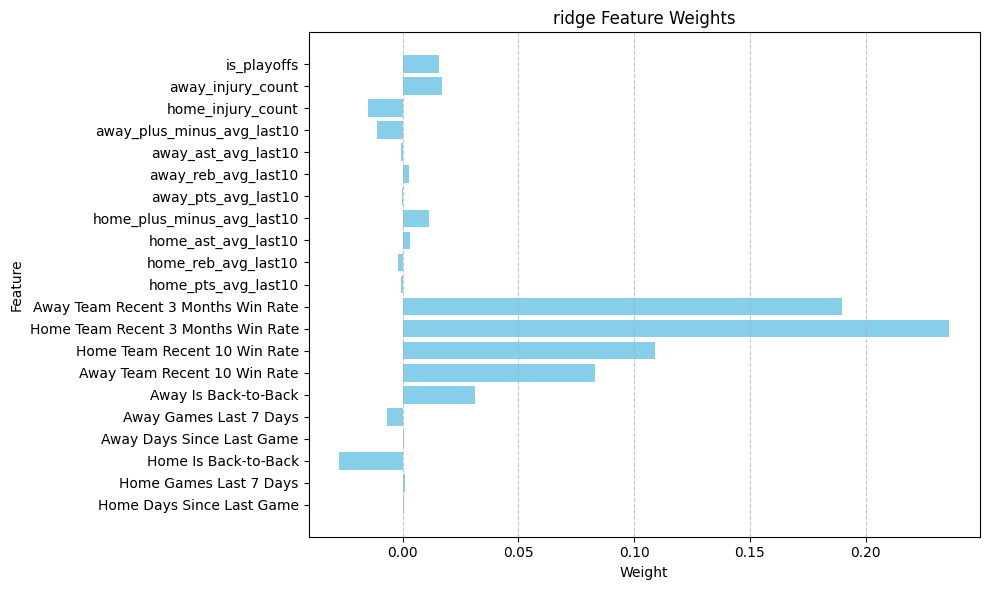

In [10]:
# 获取特征名称和对应的权重
feature_names = X_train.columns
weights = ridge.coef_  

# 可视化权重
plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('ridge Feature Weights')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 创建XGBoost分类器
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 训练模型
xgb_model.fit(X_train, y_train_binary)

# 在测试集上进行预测
y_pred_xgb = xgb_model.predict(X_test)

# 输出分类报告
print(classification_report(y_test_binary, y_pred_xgb))

C:\Users\fanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [09:47:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.57      0.44      0.50      2364
           1       0.67      0.77      0.71      3404

    accuracy                           0.64      5768
   macro avg       0.62      0.61      0.61      5768
weighted avg       0.63      0.64      0.63      5768



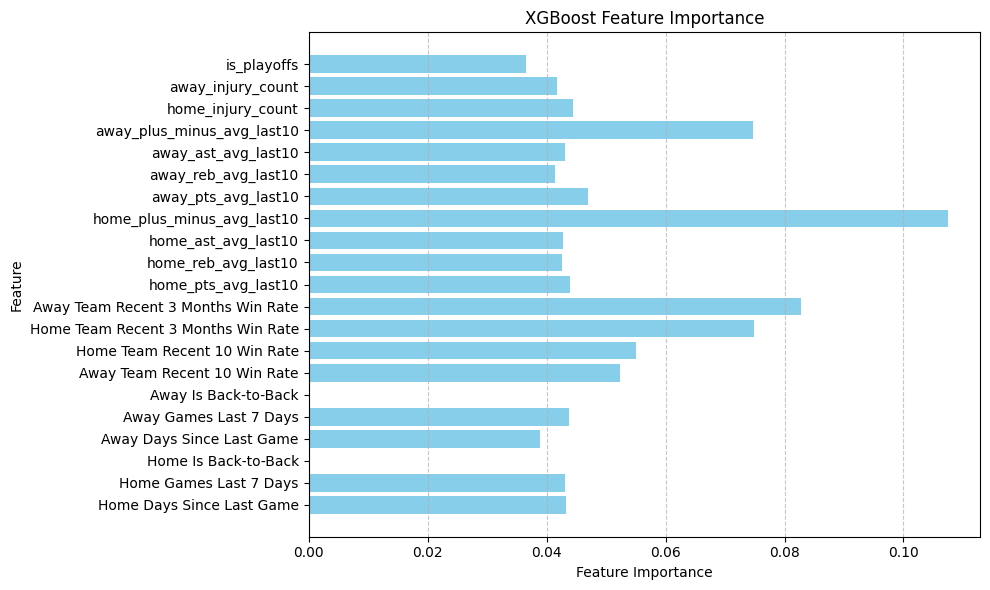

In [16]:
# 提取特征重要性
xgb_feature_importance = xgb_model.feature_importances_

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(feature_names, xgb_feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# 创建LightGBM分类器
lgbm_model = LGBMClassifier()

# 训练模型
lgbm_model.fit(X_train, y_train_binary)

# 在测试集上进行预测
y_pred_lgbm = lgbm_model.predict(X_test)

# 输出分类报告
print(classification_report(y_test_binary, y_pred_lgbm))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13649, number of negative: 9423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2474
[LightGBM] [Info] Number of data points in the train set: 23072, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.591583 -> initscore=0.370513
[LightGBM] [Info] Start training from score 0.370513
              precision    recall  f1-score   support

           0       0.59      0.44      0.50      2364
           1       0.67      0.79      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.63      0.61      0.61      5768
weighted avg       0.64      0.65      0.63      5768

